<a name='1'></a>
## 1 - Imports

In [1]:
import os
import numpy as np
import pandas as pd
import imageio as iio
import tensorflow as tf
from model import *
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Conv2DTranspose,
    concatenate,
)
import matplotlib.pyplot as plt

%matplotlib inline

<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
path = ""
mask_path = os.path.join(
    path, "./data/classes_dataset/classes_dataset/label_images_semantic/"
)
image_path = os.path.join(
    path, "./data/classes_dataset/classes_dataset/original_images/"
)
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

Text(0.5, 1.0, 'Segmentation')

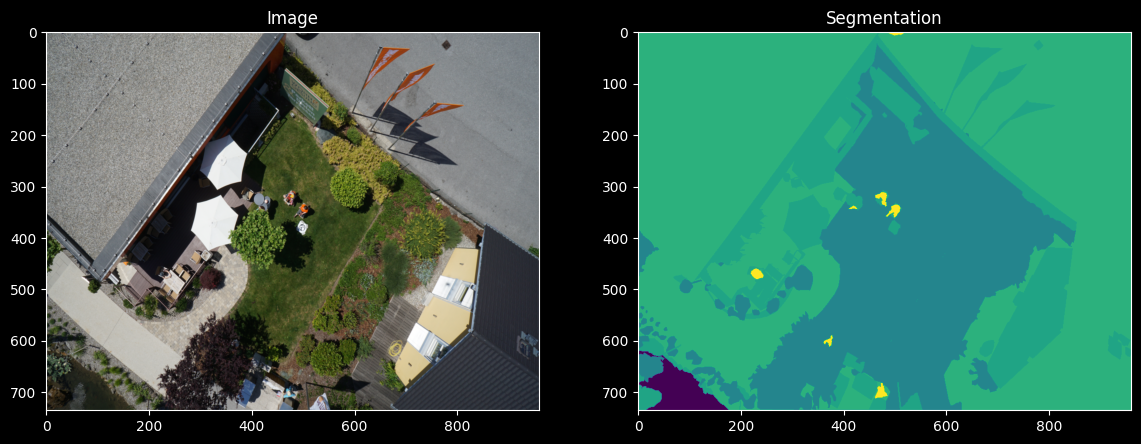

In [3]:
N = 3
img = iio.v3.imread(image_list[N])
mask = iio.v3.imread(mask_list[N])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title("Image")
arr[1].imshow(mask[:, :, 0])
arr[1].set_title("Segmentation")

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/original_images/000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/label_images_semantic/000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/original_images/001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/label_images_semantic/001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/original_images/002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/classes_dataset/classes_dataset/label_images_semantic/002.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/classes_dataset/classes_dataset/original_images/348.png', shape=(), dtype=string)
tf.Tensor(b'./data/classes_dataset/classes_dataset/label_images_semantic/348.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data
Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask


def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method="nearest")
    input_mask = tf.image.resize(mask, (96, 128), method="nearest")

    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [7]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [8]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [9]:
unet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

(736, 960, 1)


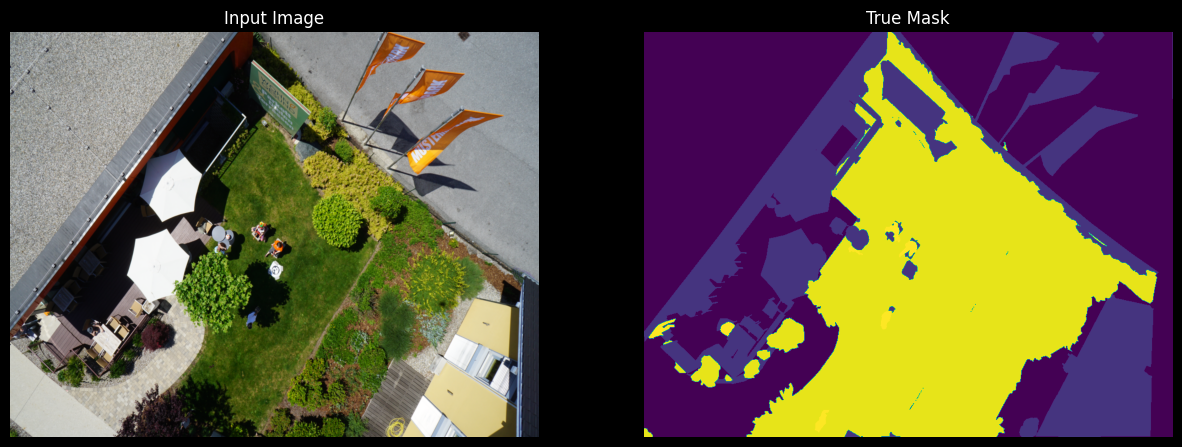

In [11]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


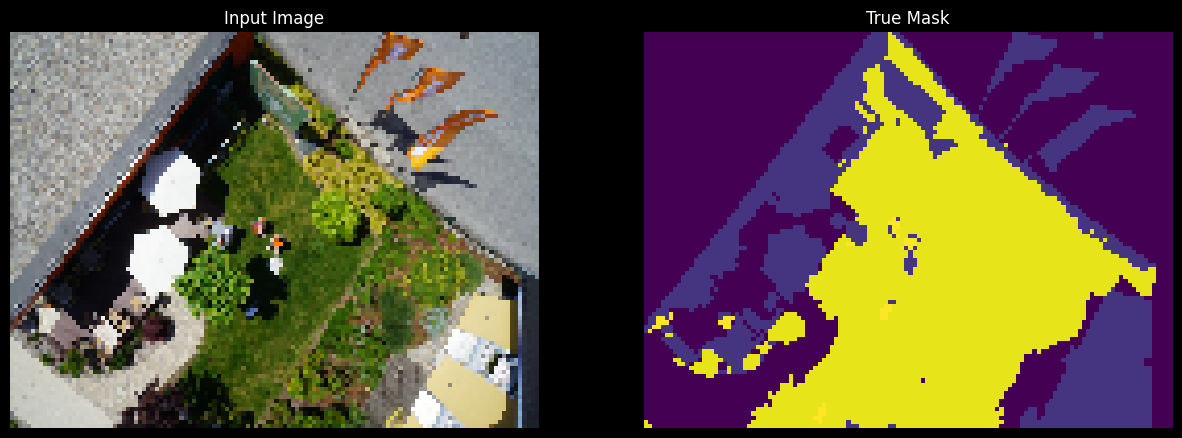

In [12]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [13]:
EPOCHS = 60
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500

BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/60


13/13 [==============================] - 36s 3s/step - loss: 7.7320 - accuracy: 0.2057
Epoch 2/60
13/13 [==============================] - 36s 3s/step - loss: 2.5171 - accuracy: 0.4642
Epoch 3/60
13/13 [==============================] - 35s 3s/step - loss: 1.3070 - accuracy: 0.5024
Epoch 4/60
13/13 [==============================] - 36s 3s/step - loss: 1.1511 - accuracy: 0.5504
Epoch 5/60
13/13 [==============================] - 33s 3s/step - loss: 1.0718 - accuracy: 0.5842
Epoch 6/60
13/13 [==============================] - 32s 2s/step - loss: 0.9250 - accuracy: 0.7067
Epoch 7/60
13/13 [==============================] - 32s 2s/step - loss: 0.8244 - accuracy: 0.7466
Epoch 8/60
13/13 [==============================] - 32s 2s/step - loss: 0.7899 - accuracy: 0.7578
Epoch 9/60
13/13 [==============================] - 33s 2s/step - loss: 0.7822 - accuracy: 0.7660
Epoch 10/60
13/13 [==============================] - 32s 2s/step - loss: 0.7535 - accuracy: 0.7710
Epoch 11/60
13/13 [===========

In [16]:
unet.save('unet.keras')

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

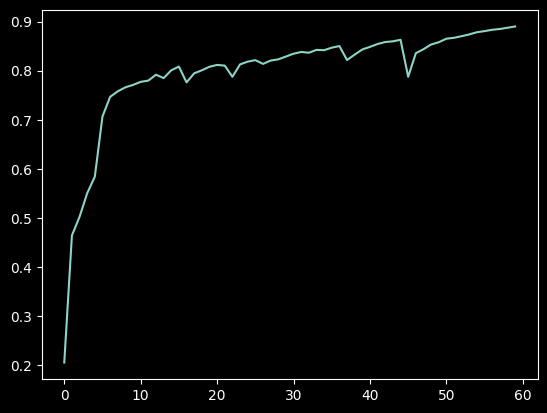

In [18]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [19]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(unet.predict(sample_image[tf.newaxis, ...])),
            ]
        )

1/1 [==============================] - 1s 754ms/step


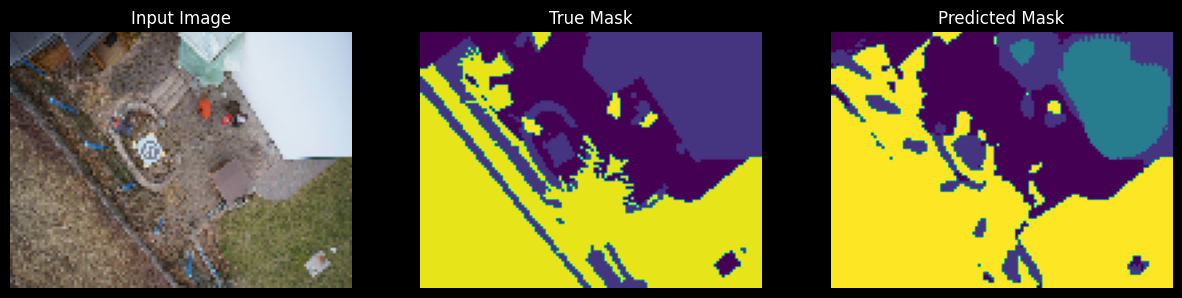

1/1 [==============================] - 1s 794ms/step


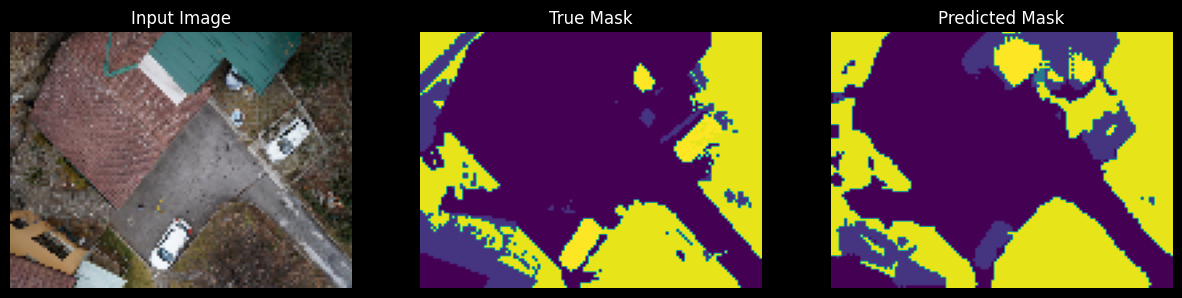

1/1 [==============================] - 1s 772ms/step


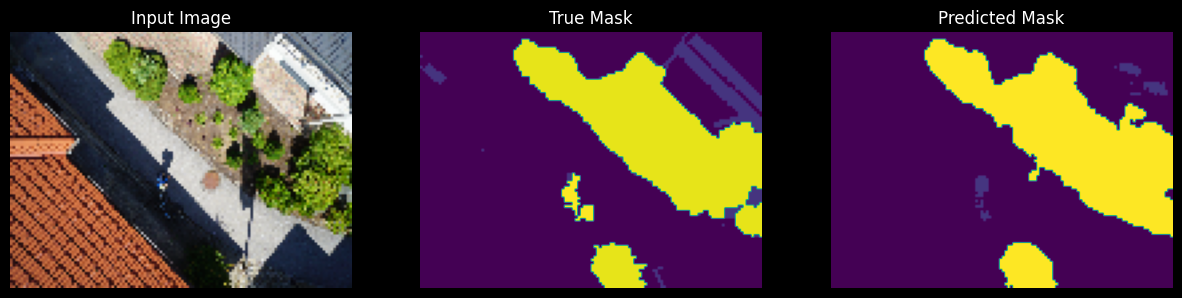

1/1 [==============================] - 1s 748ms/step


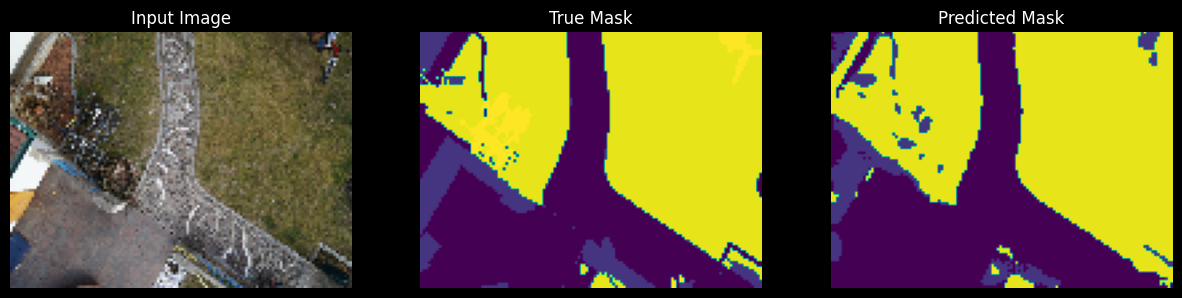

1/1 [==============================] - 1s 749ms/step


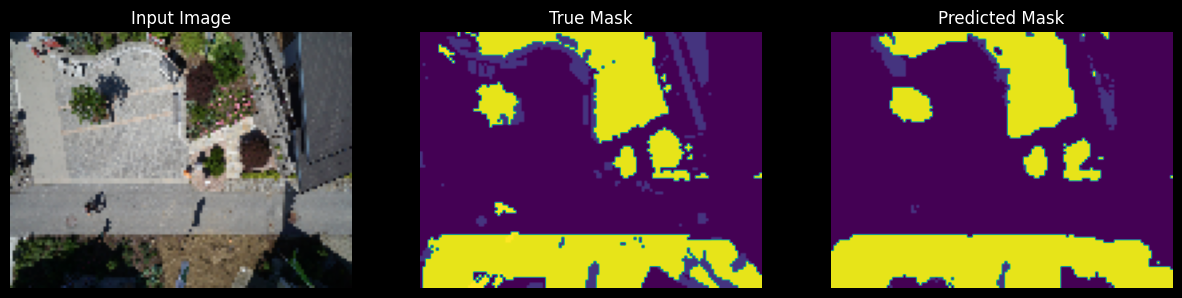

1/1 [==============================] - 1s 832ms/step


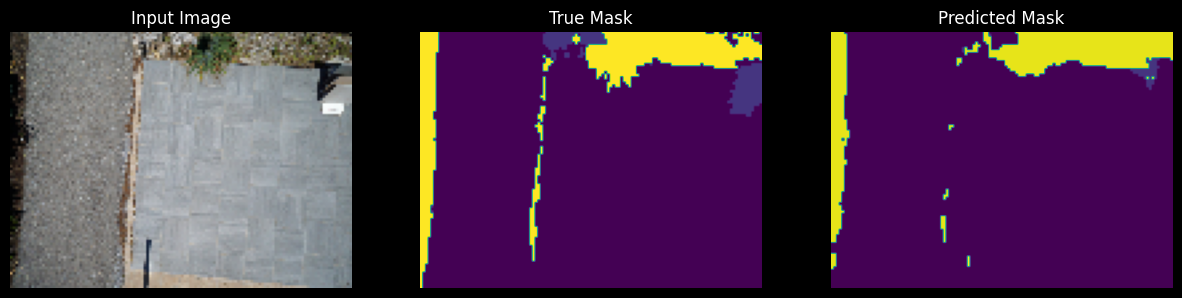

In [20]:
show_predictions(train_dataset,6)